#Task#1: **COVID Analysis**

###Import statements

In [126]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

In [127]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


###Loading and Normalization of data

In [128]:
# Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io as io
import glob
import pandas as pd
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
from torchvision.models import ResNet18_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Dataloader Class
class MyDataset(torch_dataset):
    def __init__(self, path, filenamelist, labellist, transform=None):
        self.path = path
        self.filenamelist = filenamelist
        self.labellist = labellist
        self.transform = transform

    def __len__(self):
        return len(self.filenamelist)

    def __getitem__(self, idx):
        I = io.imread(self.path + self.filenamelist[idx])
        I = skimage.util.img_as_float32(I)
        I = I.reshape(1, I.shape[0], I.shape[1])
        I = torch.tensor(I, dtype=torch.float32)
        I = I.expand(3, I.shape[1], I.shape[2])
        label = torch.tensor(self.labellist[idx], dtype=torch.int64).unsqueeze(0)

        if self.transform:
            I = self.transform(I)

        return I, label

# Dataloader Function
def get_dataloader(path='/content/drive/MyDrive/HW#5_CSC_546/S224/'):
    df_train = pd.read_csv(path + 'train.csv')
    dataset_train = MyDataset(path, df_train['filename'].values, df_train['label'].values, transform=data_transforms['train'])
    loader_train = torch_dataloader(dataset_train, batch_size=16, num_workers=0, shuffle=True)

    df_val = pd.read_csv(path + 'val.csv')
    dataset_val = MyDataset(path, df_val['filename'].values, df_val['label'].values, transform=data_transforms['val'])
    loader_val = torch_dataloader(dataset_val, batch_size=10, num_workers=0, shuffle=False)

    df_test = pd.read_csv(path + 'test.csv')
    dataset_test = MyDataset(path, df_test['filename'].values, df_test['label'].values, transform=data_transforms['test'])
    loader_test = torch_dataloader(dataset_test, batch_size=10, num_workers=0, shuffle=False)

    return loader_train, loader_val, loader_test


Using device: cuda


In [129]:
dataloader_path = '/content/drive/MyDrive/HW#5_CSC_546/S224/'
loader_train, loader_val, loader_test = get_dataloader(dataloader_path)

for images, labels in loader_test:
    print(f"Test Batch - Images Shape: {images.shape}, Labels Shape: {labels.shape}")
    break


Test Batch - Images Shape: torch.Size([10, 3, 224, 224]), Labels Shape: torch.Size([10, 1])


Sample batch output displayed

In [131]:
dataloader_path = '/content/drive/MyDrive/HW#5_CSC_546/S224/'
loader_train, loader_val, loader_test = get_dataloader(dataloader_path)
# Inspect a batch from the training loader
for images, labels in loader_train:
    print("Batch of images shape:", images.shape)  # Should be [batch_size, 3, H, W]
    print("Batch of labels shape:", labels.shape)  # Should be [batch_size, 1]
    break  # Exit after checking one batch

Batch of images shape: torch.Size([16, 3, 224, 224])
Batch of labels shape: torch.Size([16, 1])


###Ensuring no overlap between data

In [132]:
def check_overlap(path):
    df_train = pd.read_csv(path + 'train.csv')
    df_val = pd.read_csv(path + 'val.csv')
    df_test = pd.read_csv(path + 'test.csv')

    train_files = set(df_train['filename'])
    val_files = set(df_val['filename'])
    test_files = set(df_test['filename'])

    print(f"Train size: {len(train_files)}, Val size: {len(val_files)}, Test size: {len(test_files)}")
    print(f"Train-Val Overlap: {len(train_files & val_files)}")
    print(f"Train-Test Overlap: {len(train_files & test_files)}")
    print(f"Val-Test Overlap: {len(val_files & test_files)}")

check_overlap('/content/drive/MyDrive/HW#5_CSC_546/S224/')


Train size: 2022, Val size: 60, Test size: 400
Train-Val Overlap: 0
Train-Test Overlap: 0
Val-Test Overlap: 0


Ensuring data is being correctly read
I checked that each filename belongs to each test/train/val, and that the correct pictures are being correctly read.

###Visualising images from each set (normalized)

Number of images in Training dataset: 2022


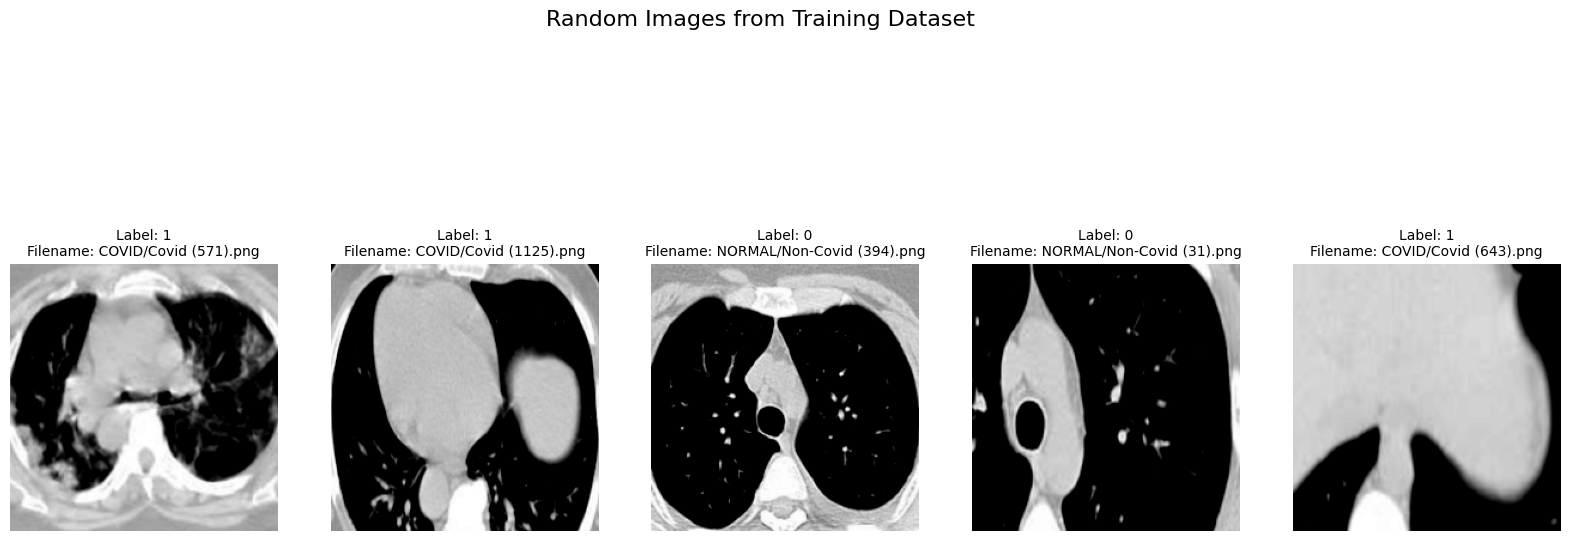

Number of images in Validation dataset: 60


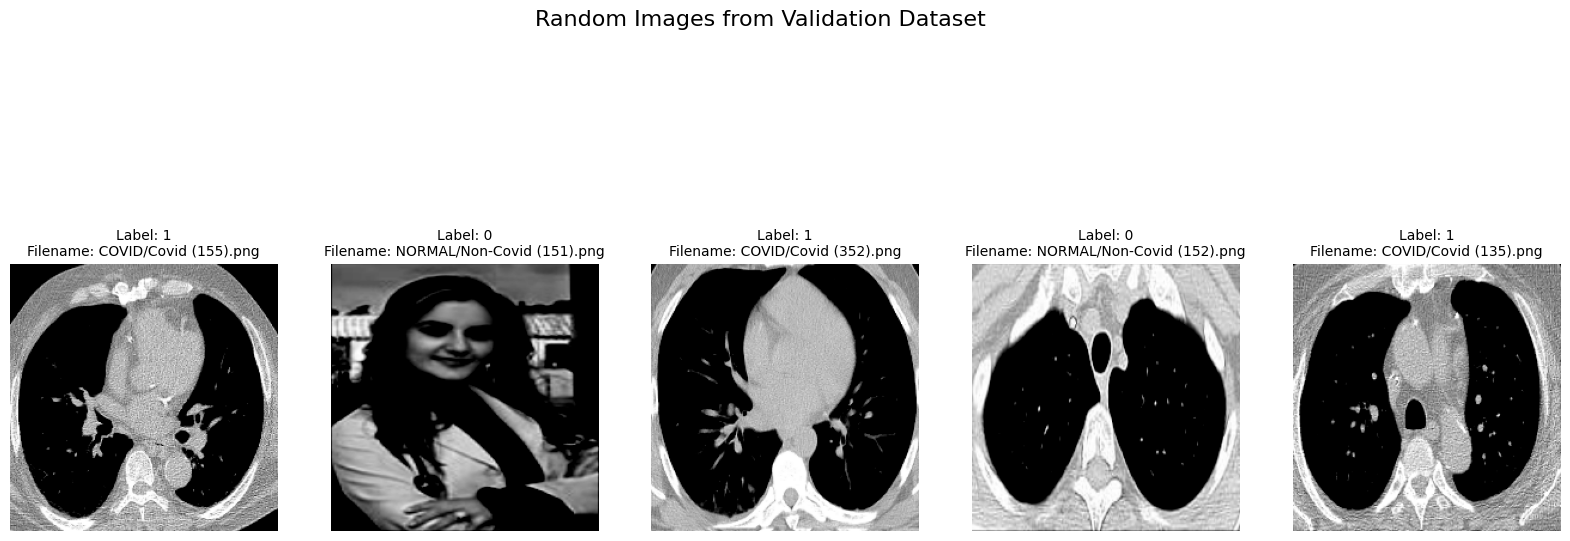

Number of images in Test dataset: 400


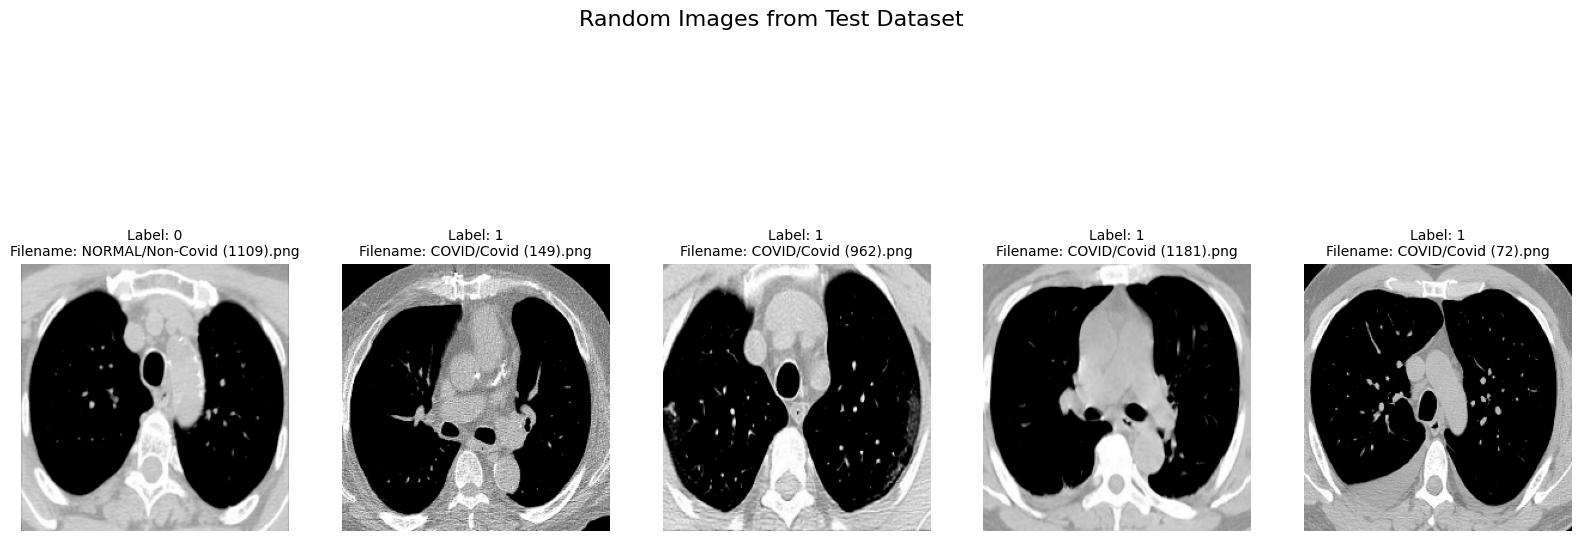

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to visualize five random images in a batch
def visualize_random_images(loader, dataset_name):
    # Get the total number of images in the dataset
    dataset_size = len(loader.dataset)

    # Select five random indices
    random_indices = random.sample(range(dataset_size), 5)

    # Create a list to store the selected images and labels
    images_to_plot = []
    labels_to_plot = []
    filenames_to_plot = []

    # Iterate through the random indices and load the corresponding images
    for idx in random_indices:
        image, label = loader.dataset[idx]  # Get image and label using dataset indexing
        images_to_plot.append(image)
        labels_to_plot.append(label)
        filenames_to_plot.append(loader.dataset.filenamelist[idx])

    # Convert the images to the correct shape for visualization
    images_to_plot = [img.numpy().transpose((1, 2, 0)) for img in images_to_plot]

    # Print number of images
    print(f"Number of images in {dataset_name} dataset: {dataset_size}")

    # Plot the selected random images horizontally
    fig, axes = plt.subplots(1, 5, figsize=(20, 8))
    fig.suptitle(f"Random Images from {dataset_name} Dataset", fontsize=16)

    for i, ax in enumerate(axes):
        ax.imshow(images_to_plot[i])
        ax.set_title(f"Label: {labels_to_plot[i].item()}\nFilename: {filenames_to_plot[i]}", fontsize=10)
        ax.axis("off")

    plt.show()

# Visualize random images from each dataset
visualize_random_images(loader_train, "Training")
visualize_random_images(loader_val, "Validation")
visualize_random_images(loader_test, "Test")

###Making an evaluation function

In [134]:
def evaluate_model(model, loader_test, criterion):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in loader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).view(-1)  # Ensure outputs are flattened
            labels = labels.float().view(-1)  # Flatten labels to match

            loss = criterion(outputs, labels)  # Compute loss on GPU
            test_loss += loss.item()

            predicted = (outputs > 0.5).float()  # Threshold for binary classification
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    test_accuracy = correct_predictions / total_predictions
    print(f"Test Loss: {test_loss/len(loader_test):.4f}, Test Accuracy: {test_accuracy*100:.2f}%")


##(1): construct a CNN by modifying Resnet-18 or Resnet-50 for binary classification.

In [135]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class ResNet18Binary(nn.Module):
    def __init__(self, use_pretrained):
        super(ResNet18Binary, self).__init__()

        # Use pretrained or initialize from scratch
        if use_pretrained:
            self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
            # Freeze all layers initially
            for param in self.resnet.parameters():
                param.requires_grad = False

            # Unfreeze specific layers for training
            for param in self.resnet.layer4.parameters():
                param.requires_grad = True
            for param in self.resnet.fc.parameters():
                param.requires_grad = True
        else:
            # Initialize from scratch, make all layers trainable
            self.resnet = models.resnet18(weights=None)

        # Modify the final fully connected layer for binary classification
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)

    def forward(self, x):
        x = self.resnet(x)  # Output logits directly, no sigmoid here
        return x  # BCEWithLogitsLoss will handle sigmoid activation

print("ResNet18Binary class created")


ResNet18Binary class created


Create save checkpoint function

In [136]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result': result},
               filename)
    print(f'Saved: {filename}')


##(2) and (3): train the CNN from scratch (random weights) and on a pre-trained model, evaluate both on the test set.

In [137]:
def train_model(use_pretrained, epochs=30, lr=1e-5):
    model = ResNet18Binary(use_pretrained=use_pretrained).to(device)
    if use_pretrained == True:
        print("Using Pretrained Model")
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

    else:
        print("Using Scratch Model")
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    loader_train, loader_val, loader_test = get_dataloader()

    loss_train_list = []
    acc_train_list = []
    acc_val_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in loader_train:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images).view(-1)
            labels = labels.float().view(-1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            running_loss += loss.item()

        train_accuracy = correct_predictions / total_predictions
        train_loss = running_loss / len(loader_train)
        loss_train_list.append(train_loss)
        acc_train_list.append(train_accuracy)

        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0

        with torch.no_grad():
            for val_images, val_labels in loader_val:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images).view(-1)
                val_labels = val_labels.float().view(-1)

                val_loss += criterion(val_outputs, val_labels).item()
                val_predicted = (val_outputs > 0.5).float()
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_accuracy = val_correct / val_total
        val_loss /= len(loader_val)
        acc_val_list.append(val_accuracy)
        scheduler.step(val_loss)

        #Saving Logic
        if use_pretrained:
           save_checkpoint(f'pretrained_epoch{epoch:02d}.pt', model, optimizer, val_accuracy, epoch)
        else:
           save_checkpoint(f'scratch_epoch{epoch:02d}.pt', model, optimizer, val_accuracy, epoch)

        print(f"Epoch [{epoch}/{epochs-1}] | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")
        print("-" * 50)


    # Get the best epoch from the validation list
    best_epoch = acc_val_list.index(max(acc_val_list))
    print(f"Best Epoch: {best_epoch}, Best Validation Accuracy: {acc_val_list[best_epoch]*100:.2f}%")

    return loss_train_list, acc_train_list, acc_val_list, best_epoch


#Scratch model

Using Scratch Model


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Saved: scratch_epoch00.pt
Epoch [0/29] | Train Loss: 0.6337, Train Acc: 60.98% | Val Loss: 0.6771, Val Acc: 73.33%
--------------------------------------------------
Saved: scratch_epoch01.pt
Epoch [1/29] | Train Loss: 0.6515, Train Acc: 72.65% | Val Loss: 1.6781, Val Acc: 70.00%
--------------------------------------------------
Saved: scratch_epoch02.pt
Epoch [2/29] | Train Loss: 0.5198, Train Acc: 75.82% | Val Loss: 0.7585, Val Acc: 81.67%
--------------------------------------------------
Saved: scratch_epoch03.pt
Epoch [3/29] | Train Loss: 0.4496, Train Acc: 78.54% | Val Loss: 0.5040, Val Acc: 80.00%
--------------------------------------------------
Saved: scratch_epoch04.pt
Epoch [4/29] | Train Loss: 0.4670, Train Acc: 78.34% | Val Loss: 0.7364, Val Acc: 85.00%
--------------------------------------------------
Saved: scratch_epoch05.pt
Epoch [5/29] | Train Loss: 0.4325, Train Acc: 81.16% | Val Loss: 2.5417, Val Acc: 50.00%
--------------------------------------------------
Save

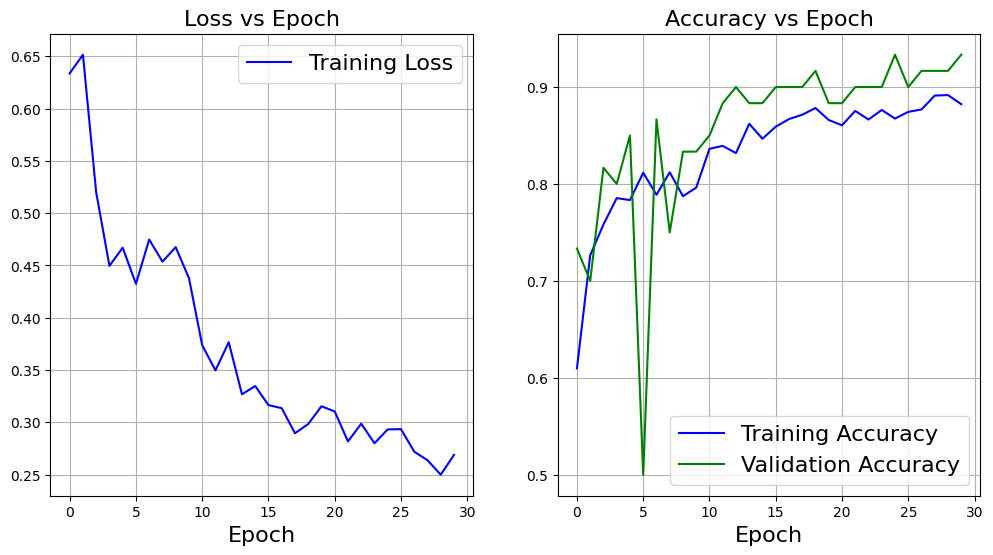

In [138]:
# Train the model from scratch
loss_train_list, acc_train_list, acc_val_list, best_epoch_scratch = train_model(use_pretrained=False)

# Plot Training Metrics
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Plot Training Loss
ax[0].set_title('Loss vs Epoch', fontsize=16)
ax[0].plot(loss_train_list, '-b', label='Training Loss')
ax[0].set_xlabel('Epoch', fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)

# Plot Training and Validation Accuracy
ax[1].set_title('Accuracy vs Epoch', fontsize=16)
ax[1].plot(acc_train_list, '-b', label='Training Accuracy')
ax[1].plot(acc_val_list, '-g', label='Validation Accuracy')
ax[1].set_xlabel('Epoch', fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

plt.show()


##Evaluate on test set using the best epoch

In [139]:
# Load the Best Model Checkpoint
checkpoint_scratch = torch.load(f'scratch_epoch{best_epoch_scratch:02d}.pt')
print(f"Best Epoch Loaded: {best_epoch_scratch}")

# Initialize Model
model = ResNet18Binary(use_pretrained=False)
model.load_state_dict(checkpoint_scratch['model_state_dict'])
model.to(device)

# Evaluate the Model on the Test Set
evaluate_model(model, loader_test, nn.BCEWithLogitsLoss())


<ipython-input-139-fd670f75fb4b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_scratch = torch.load(f'scratch_epoch{best_epoch_scratch:02d}.pt')


Best Epoch Loaded: 24
Test Loss: 0.2437, Test Accuracy: 91.50%


#Pre-trained model

Using Pretrained Model


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Saved: pretrained_epoch00.pt
Epoch [0/29] | Train Loss: 0.4223, Train Acc: 80.07% | Val Loss: 0.4127, Val Acc: 83.33%
--------------------------------------------------
Saved: pretrained_epoch01.pt
Epoch [1/29] | Train Loss: 0.3031, Train Acc: 87.14% | Val Loss: 0.3212, Val Acc: 88.33%
--------------------------------------------------
Saved: pretrained_epoch02.pt
Epoch [2/29] | Train Loss: 0.2638, Train Acc: 88.08% | Val Loss: 0.4477, Val Acc: 81.67%
--------------------------------------------------
Saved: pretrained_epoch03.pt
Epoch [3/29] | Train Loss: 0.2363, Train Acc: 90.41% | Val Loss: 0.3079, Val Acc: 86.67%
--------------------------------------------------
Saved: pretrained_epoch04.pt
Epoch [4/29] | Train Loss: 0.2391, Train Acc: 89.37% | Val Loss: 0.2524, Val Acc: 86.67%
--------------------------------------------------
Saved: pretrained_epoch05.pt
Epoch [5/29] | Train Loss: 0.2082, Train Acc: 90.95% | Val Loss: 0.4226, Val Acc: 85.00%
-------------------------------------

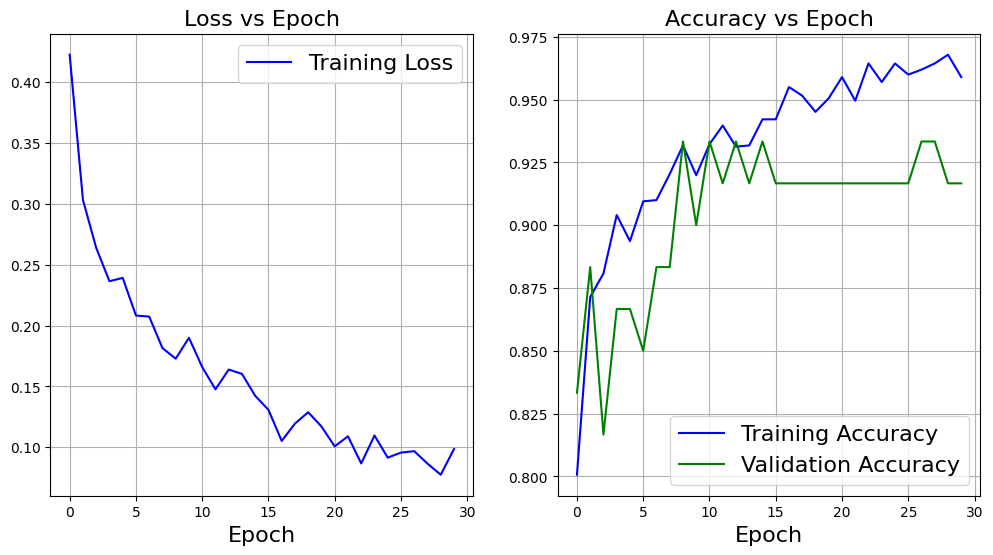

In [140]:
# Train the model using transfered learning
loss_train_list, acc_train_list, acc_val_list, best_epoch_pretrained = train_model(use_pretrained=True)

# Plot Training Metrics
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Plot Training Loss
ax[0].set_title('Loss vs Epoch', fontsize=16)
ax[0].plot(loss_train_list, '-b', label='Training Loss')
ax[0].set_xlabel('Epoch', fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)

# Plot Training and Validation Accuracy
ax[1].set_title('Accuracy vs Epoch', fontsize=16)
ax[1].plot(acc_train_list, '-b', label='Training Accuracy')
ax[1].plot(acc_val_list, '-g', label='Validation Accuracy')
ax[1].set_xlabel('Epoch', fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

plt.show()

##Evaluate on test set using the best epoch

In [141]:
# Load the Best Pretrained Model
checkpoint_trained = torch.load(f'pretrained_epoch{best_epoch_pretrained:02d}.pt')
print(f"Best Epoch Pretrained: {best_epoch_pretrained}")

# Initialize Model
model = ResNet18Binary(use_pretrained=True)
model.load_state_dict(checkpoint_trained['model_state_dict'])
model.to(device)

# Evaluate the Model on the Test Set
evaluate_model(model, loader_test, nn.BCEWithLogitsLoss())


<ipython-input-141-6e44df160c3d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_trained = torch.load(f'pretrained_epoch{best_epoch_pretrained:02d}.pt')


Best Epoch Pretrained: 8
Test Loss: 0.1321, Test Accuracy: 95.75%


## (4): GradCAM + EigenCAM visualization

In [142]:
!pip install grad-cam

In [143]:
import random
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision.transforms import Normalize

##Select ten random images from test set

In [151]:
# Image Selection Function
def select_images(loader, num_samples=10):
    covid_images, non_covid_images = [], []
    for images, labels in loader:
        for img, label in zip(images, labels):
            if label == 1 and len(covid_images) < num_samples:
                covid_images.append((img, label))
            elif label == 0 and len(non_covid_images) < num_samples:
                non_covid_images.append((img, label))
            if len(covid_images) >= num_samples and len(non_covid_images) >= num_samples:
                break

    # Randomly shuffle within each class, but keep classes grouped
    random.shuffle(covid_images)
    random.shuffle(non_covid_images)
    return covid_images + non_covid_images

# Select Images
selected_images = select_images(loader_test)


##Visualization for both models. (10 COVID, 10 NON-COVID)
####Ensured that “category” in BinaryClassifierOutputTarget must be the same as the class label of the image used for CAM using "targets = [BinaryClassifierOutputTarget(int(label.item()))])[0]"

<ipython-input-159-59573d1cd60a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_scratch = torch.load(f'scratch_epoch{best_epoch_scratch:02d}.pt')
<ipython-input

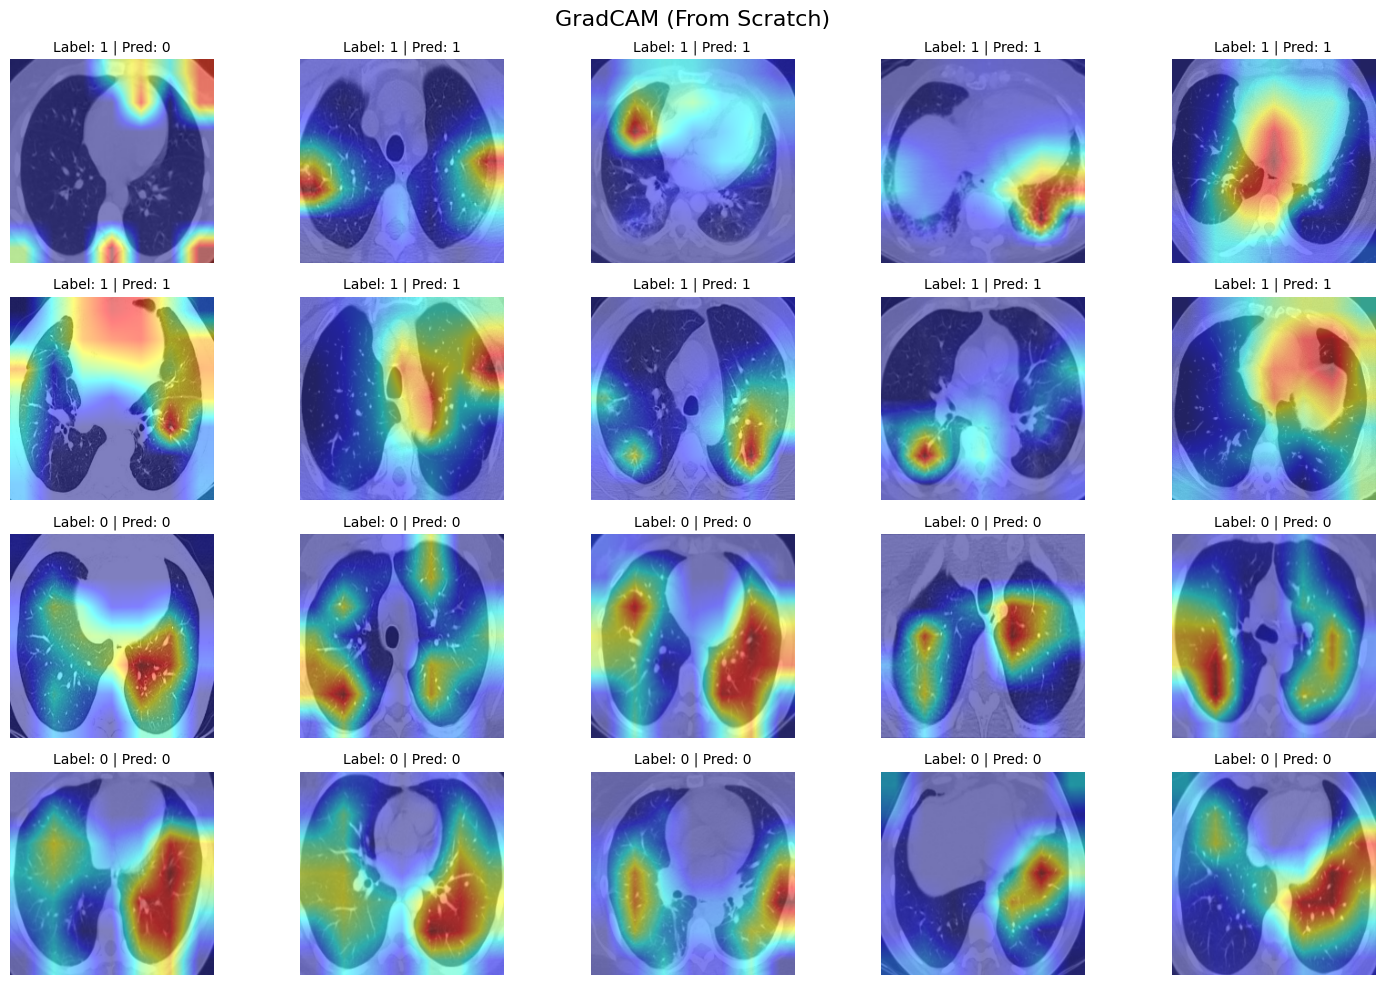

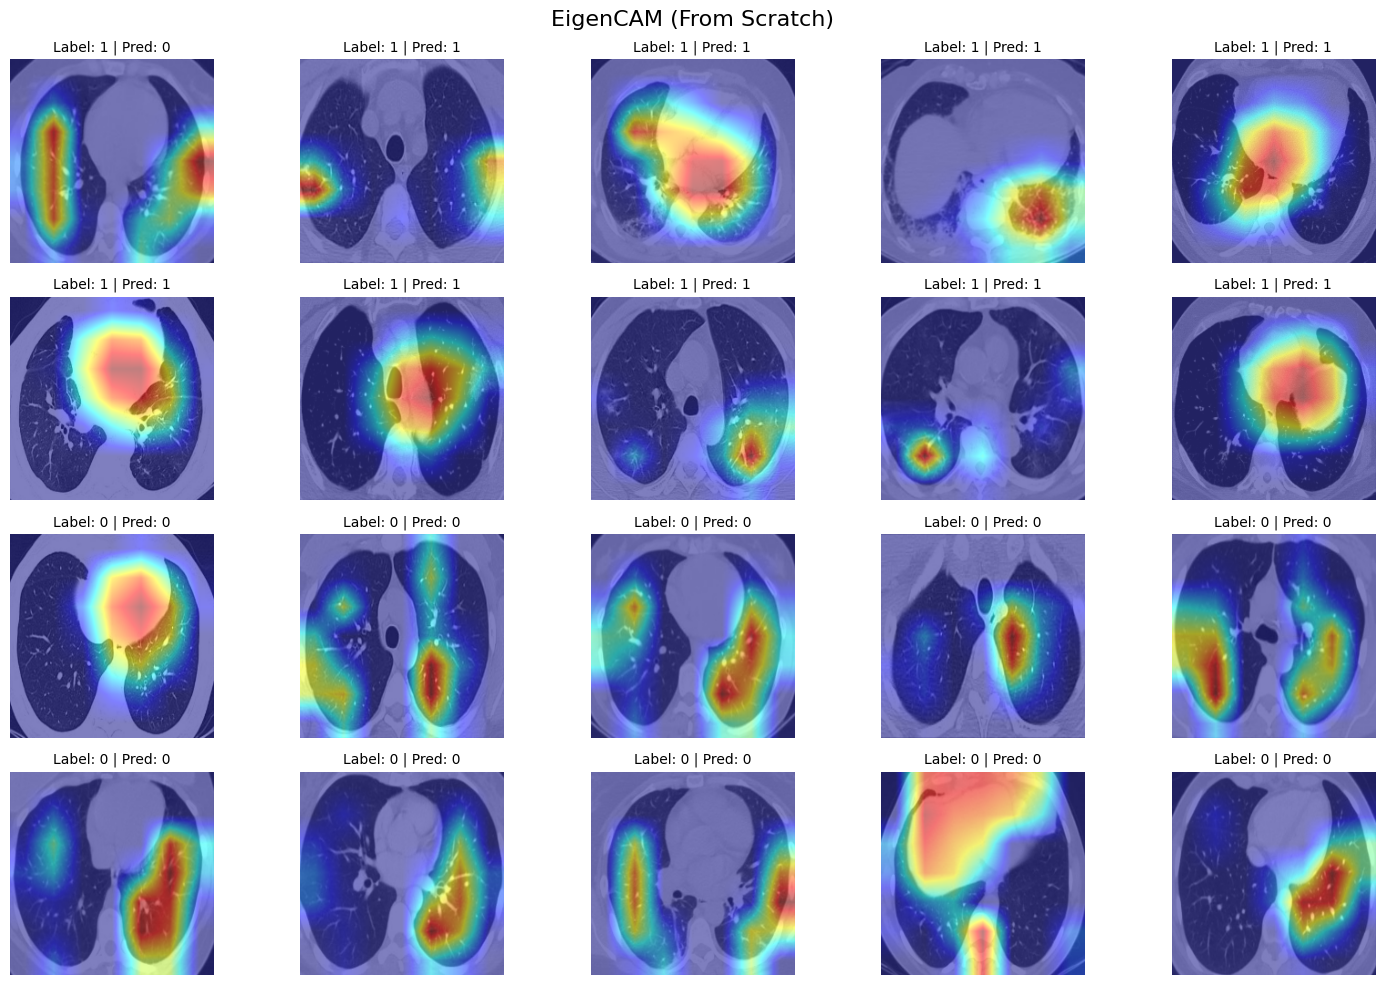

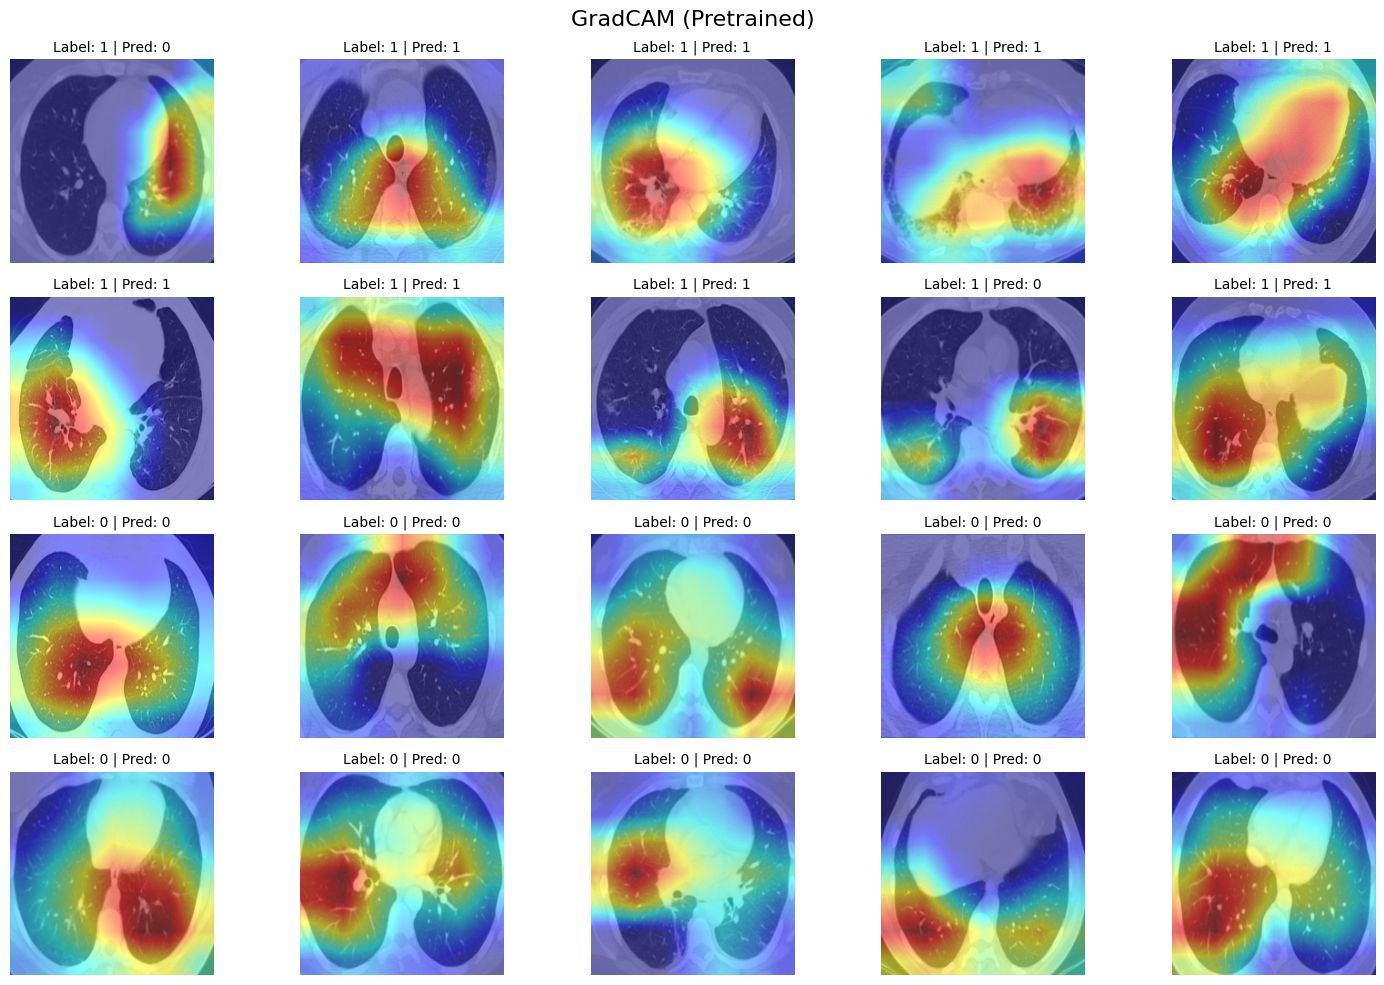

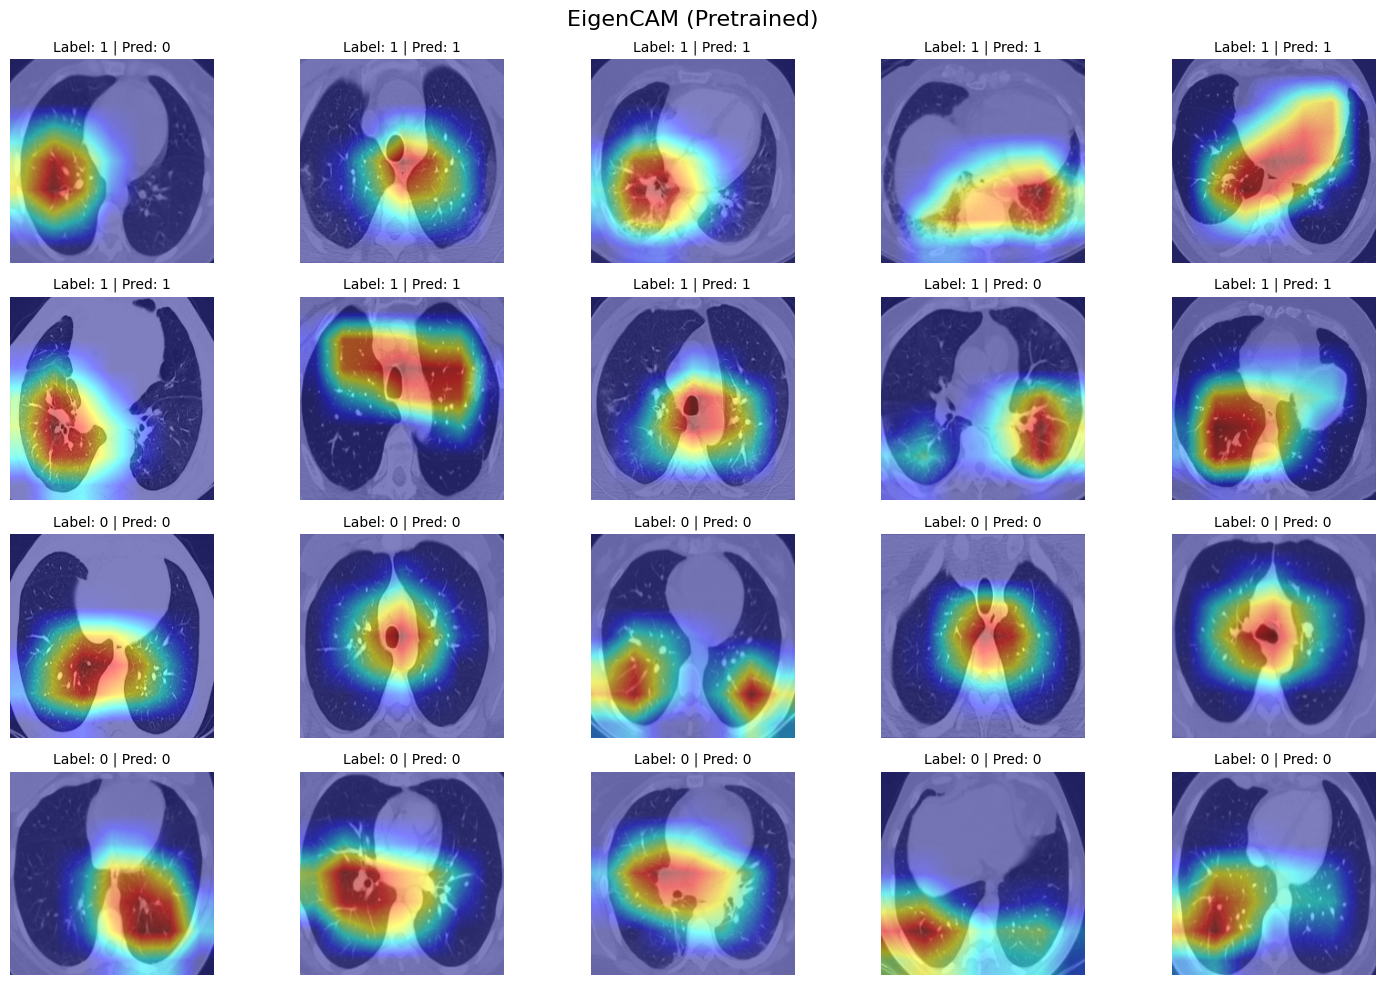

In [159]:

import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget

# Load Saved Checkpoints Safely
checkpoint_scratch = torch.load(f'scratch_epoch{best_epoch_scratch:02d}.pt')
checkpoint_trained = torch.load(f'pretrained_epoch{best_epoch_pretrained:02d}.pt')

# Initialize and Load Models
model_scratch = ResNet18Binary(use_pretrained=False).to(device)
model_scratch.load_state_dict(checkpoint_scratch['model_state_dict'])
model_scratch.eval()

model_pretrained = ResNet18Binary(use_pretrained=True).to(device)
model_pretrained.load_state_dict(checkpoint_trained['model_state_dict'])
model_pretrained.eval()

# Visualization Function
def visualize_cam(model, target_layer, method, images, title):
    cam = method(model=model, target_layers=[target_layer])
    plt.figure(figsize=(15, 10))

    for i, (image, label) in enumerate(images):
        input_tensor = image.unsqueeze(0).to(device)

        # Correct Target Selection
        grayscale_cam = cam(input_tensor=input_tensor, targets=[BinaryClassifierOutputTarget(int(label.item()))])[0]

        # Normalize CAM
        grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

        # Correct Image Normalization
        image_np = (image.permute(1, 2, 0).cpu().numpy() * 0.5) + 0.5
        image_np = np.clip(image_np, 0, 1)

        # Generate CAM Image
        cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

        # Generate Model Prediction
        prediction = model(input_tensor)
        predicted_label = (prediction > 0.5).float().item()

        # Display Results
        plt.subplot(4, 5, i + 1)
        plt.imshow(cam_image)
        plt.title(f'Label: {label.item()} | Pred: {int(predicted_label)}', fontsize=10)
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()



# Set Target Layers
target_layer_scratch = model_scratch.resnet.layer4[-1]
target_layer_pretrained = model_pretrained.resnet.layer4[-1]

# Apply Grad-CAM and Eigen-CAM Visualizations
visualize_cam(model_scratch, target_layer_scratch, GradCAM, selected_images, "GradCAM (From Scratch)")
visualize_cam(model_scratch, target_layer_scratch, EigenCAM, selected_images, "EigenCAM (From Scratch)")

visualize_cam(model_pretrained, target_layer_pretrained, GradCAM, selected_images, "GradCAM (Pretrained)")
visualize_cam(model_pretrained, target_layer_pretrained, EigenCAM, selected_images, "EigenCAM (Pretrained)")

####The GradCAM seems to be showing correct activation maps, because the images where the images have incorrect predictions have activation maps that highlight edges, meaning that meaningful discoveries were not made.


#Discussion on the Benefits of Transfer Learning Compared to Learning from Scratch

###Introduction

The task involved training a ResNet-18 model from scratch and using transfer learning for COVID-19 diagnosis from CT scan images. The following discussion highlights whether transfer learning provided extra benefits based on the training and validation performance metrics observed during training.

Training Results Overview
Scratch Model Performance:
Best Validation Accuracy: 93.33% (Epoch 24)
Test Accuracy: 91.50%
Best Validation Loss: 0.3195
Training Accuracy: Improved from 60.98% to 89.17%

Pretrained Model Performance:
Best Validation Accuracy: 93.33% (Epoch 8)
Test Accuracy: 95.75%
Best Validation Loss: 0.1597
Training Accuracy: Improved from 80.07% to 96.79%

###Analysis of Results
1. Training Efficiency:
The pretrained model converged much faster, achieving its peak validation accuracy of 93.33% at Epoch 8, while the scratch model required 24 epochs. This demonstrates that transfer learning allowed the model to learn faster by leveraging pre-learned features from ImageNet.

2. Generalization Performance:
The pretrained model achieved a significantly higher test accuracy of 95.75% compared to 91.50% from the scratch model. This indicates that the pretrained model generalized better to unseen test data, showing the advantage of learned feature representations.

3. Validation Loss Stability:
The pretrained model demonstrated lower and more stable validation losses throughout training. In contrast, the scratch model had more fluctuating validation losses, indicating potential challenges with stability and overfitting.

4. Early Overfitting in the Scratch Model:
The scratch model experienced some overfitting after Epoch 18, with validation loss spikes and reduced validation accuracy despite improvements in training accuracy. This was less pronounced in the pretrained model due to its initialization with robust feature representations.

###Conclusion
Transfer learning provided significant advantages over training from scratch in this task. The pretrained ResNet-18 model:
Learned faster, requiring fewer epochs to achieve peak performance.
Generalized better, achieving higher test accuracy.
Was more stable, showing less fluctuation in validation loss.
These findings confirm that transfer learning is highly beneficial for tasks with limited datasets, as it leverages pre-learned features and reduces training time while enhancing generalization and stability.
Thus, transfer learning clearly provided extra benefits compared to training from scratch in this COVID-19 CT image classification task.

